# BERT Probing vs Fine-Tuning on AG News

## Overview

This project investigates the effectiveness of pretrained transformer representations for text classification. We compare:
* Frozen BERT embeddings + classical classifiers (KNN, Logistic Regression)
* End-to-end fine-tuning of BERT
* We analyze the performance gap between probing and full parameter optimization, and explore attention behavior in fine-tuned models.

### Necessary Imports

In [68]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import pandas as pd
import torch
import random
from collections import Counter
import evaluate

# HuggingFace
from datasets import load_dataset

# Transformers
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    get_scheduler,
    AutoModel,
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# PyTorch
from torch.utils.data import (
    DataLoader
)
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F


# Classical ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

### Data

In [8]:
dataset = load_dataset("ag_news")

train_dataset = dataset["train"]
test_dataset = dataset["test"]


### Dataset Exploration

Class Distribution Analysis

/var/folders/vq/2xvq3cnj2wj2z1dd7rh6hn_h0000gn/T/ipykernel_62919/1942449607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


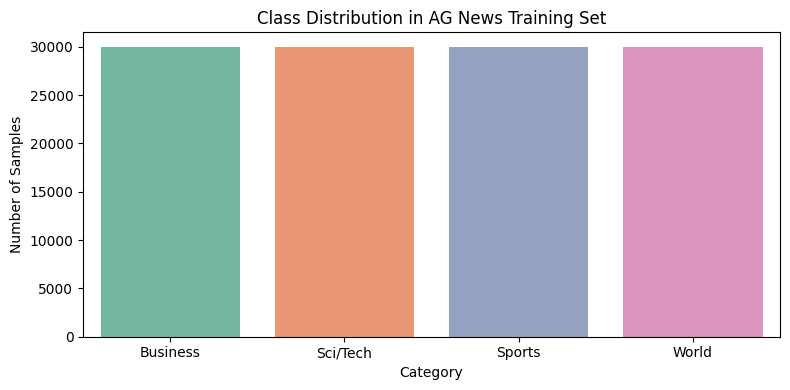

In [12]:

df_train = pd.DataFrame(train_dataset)
df_test = pd.DataFrame(test_dataset)

label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
df_train['label_name'] = df_train['label'].map(label_names)
df_test['label_name'] = df_test['label'].map(label_names)

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_train,
    x='label_name',
    palette='Set2',
    order=df_train['label_name'].value_counts().index
)
plt.title('Class Distribution in AG News Training Set')
plt.ylabel('Number of Samples')
plt.xlabel('Category')
plt.tight_layout()
plt.savefig('data_dist.jpg')

### Tokenization and Preprocessing

We tokenize the text using the DistilBERT tokenizer to prepare inputs for downstream probing and fine-tuning experiments.

In [22]:
# Getting model and data

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

tokenized_train = train_dataset.map(
    lambda x: tokenizer(x['text'], truncation=True),
    batched=True,
    remove_columns=['text']
)
tokenized_train = tokenized_train.rename_column('label', 'labels')

tokenized_test = test_dataset.map(
    lambda x: tokenizer(x['text'], truncation=True),
    batched=True,
    remove_columns=['text']
)
tokenized_test = tokenized_test.rename_column('label', 'labels')

tokenized_train.set_format(type='torch')
tokenized_test.set_format(type='torch')


Map: 100%|██████████| 7600/7600 [00:00<00:00, 19261.32 examples/s]


### DataLoader and Batching Setup

In [48]:

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

dataloaders = {
    'train': None,
    'validation': None,
    'test': None,
}

dataloaders['train'] = DataLoader(
    dataset=tokenized_train,
    batch_size=64,
    shuffle=True,
    collate_fn=data_collator,
)

dataloaders['test'] = DataLoader(
    dataset=tokenized_test,
    batch_size=64,
    shuffle=True,
    collate_fn=data_collator,
)


### Model Initialization and Optimization Setup

We initialize a DistilBERT classification model with task-specific label mappings and configure the optimizer and learning rate scheduler for fine-tuning.

In [23]:
# Define label space for classification task
num_labels = 4
id2label = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
label2id = {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

# Get model, move to device
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.to(device)

# Learning rate scheduler
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0)

num_training_epochs = 1
num_training_steps = num_training_epochs * len(dataloaders['train'])
num_warmup_steps = 0

lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1497.37it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


### Evaluation Metrics

In [26]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

### Training and Evaluation Functions

We fine-tune the model using a custom PyTorch training loop and evaluate performance using accuracy and macro F1.

In [35]:
def train(model, dataloader):
    model.train()
    loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        labels = batch['labels']

        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()

        loss += outputs.loss.item()
        accuracy_metric.add_batch(predictions=predictions, references=labels)
        f1_metric.add_batch(predictions=predictions, references=labels)

    loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='macro')
    return {'loss':loss, **accuracy, **f1}

def evaluate_model(model, dataloader):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            labels = batch['labels']
            loss += outputs.loss.item()
            accuracy_metric.add_batch(predictions=predictions, references=labels)
            f1_metric.add_batch(predictions=predictions, references=labels)
    loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='macro')
    return {'loss':loss, **accuracy, **f1}

### Representation Probing with Frozen DistilBERT

To assess the quality of pretrained representations, we extract embeddings from a frozen DistilBERT encoder and evaluate downstream performance using classical classifiers.

In [29]:
frozen_model = AutoModel.from_pretrained(checkpoint)
frozen_model.to(device)
frozen_model.eval()

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1316.05it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSelfAttention(
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

### Embedding Extraction (Mean Pooling)

We extract fixed-length sentence representations from the frozen DistilBERT encoder using attention-masked mean pooling over token embeddings.

In [30]:
def extract_embeddings(dataloader, model):
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state

            # Mean pooling
            mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
            sum_embeddings = torch.sum(hidden_states * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask

            all_embeddings.append(mean_pooled.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_embeddings), torch.cat(all_labels)

### Probing with Classical Classifiers

We evaluate the quality of frozen DistilBERT representations using KNN and Log Regression on a held-out validation split.

In [32]:
X_all, y_all = extract_embeddings(dataloaders['train'], frozen_model)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# KNN
for k in [1, 3, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"knn (k={k}): {acc:.4f}")

# LR
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
preds = lr.predict(X_val)
acc = accuracy_score(y_val, preds)
print(f"lr: {acc:.4f}")

100%|██████████| 1875/1875 [48:55<00:00,  1.57s/it] 


knn (k=1): 0.8993
knn (k=3): 0.9127
knn (k=5): 0.9167
knn (k=10): 0.9183
lr: 0.9125


### Baseline Performance (Unfinetuned BERT)

We evaluate the pretrained classification model before fine-tuning to establish a baseline for comparison.

In [36]:
test_metrics = evaluate_model(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" ; ")
print(f"F1 (MACRO): {test_metrics['f1']:.5f}")

100%|██████████| 119/119 [02:51<00:00,  1.44s/it]

TEST ACCURACY: 0.25184 ; F1 (MACRO): 0.10543


### Finetuning and Evaluation

We finetune the transformer on the training set and evaluate on the test set after each epoch using accuracy and macro F1.

In [37]:
for epoch in range(num_training_epochs):
    train_metrics = train(model, dataloaders['train'])
    test_metrics = evaluate_model(model, dataloaders['test'])
    print(f"EPOCH {epoch+1}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
    print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" ; ")
    print(f"F1 (MACRO): {test_metrics['f1']:.5f}")


100%|██████████| 119/119 [04:38<00:00,  2.34s/it]

EPOCH 1 | TRAIN LOSS: 0.21347 | TEST ACCURACY: 0.94276 ; F1 (MACRO): 0.94281


In [65]:
model.config._attn_implementation = "eager"
model.config.output_attentions = True
model.eval()
classification_model = model

### Hybrid Architecture: Frozen BERT + CNN Classifier

As an additional experiment, we freeze the DistilBERT encoder and train a lightweight CNN classifier on top of contextual token embeddings. 
This explores whether local convolutional feature extraction can improve performance over classical probing methods.

In [40]:
class CNNTextClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=4, kernel_sizes=[2, 3, 4], num_filters=100):
        super(CNNTextClassifier, self).__init__()
        self.bert = bert_model
        for param in self.bert.parameters():
            param.requires_grad = False # frozen, like we did with lr and knn

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=768, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state

        x = embeddings.permute(0, 2, 1)

        convs = [F.relu(conv(x)) for conv in self.convs]
        pools = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(2) for c in convs]
        concat = torch.cat(pools, dim=1)

        output = self.fc(self.dropout(concat))
        return output

In [41]:
cnn_model = CNNTextClassifier(frozen_model, num_classes=num_labels).to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

def train_cnn(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    for batch in tqdm(dataloader):
        cnn_optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        cnn_optimizer.step()

        predictions = torch.argmax(logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=labels)
        f1_metric.add_batch(predictions=predictions, references=labels)
        total_loss += loss.item()

    return {'loss': total_loss / len(dataloader), **accuracy_metric.compute(), **f1_metric.compute(average='macro')}

def evaluate_cnn(model, dataloader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)

            predictions = torch.argmax(logits, dim=-1)
            accuracy_metric.add_batch(predictions=predictions, references=labels)
            f1_metric.add_batch(predictions=predictions, references=labels)
            total_loss += loss.item()

    return {'loss': total_loss / len(dataloader), **accuracy_metric.compute(), **f1_metric.compute(average='macro')}

Code block to speed up training process by training and testing on subsets.

In [56]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

QUICK_TRAIN_N = 5000
QUICK_TEST_N = 2000

quick_train_ds = Subset(tokenized_train, range(min(QUICK_TRAIN_N, len(tokenized_train))))
quick_test_ds  = Subset(tokenized_test,  range(min(QUICK_TEST_N,  len(tokenized_test))))

quick_dataloaders = {
    "train": DataLoader(
        dataset=quick_train_ds,
        batch_size=dataloaders["train"].batch_size,
        shuffle=True,
        collate_fn=dataloaders["train"].collate_fn,
    ),
    "test": DataLoader(
        dataset=quick_test_ds,
        batch_size=dataloaders["test"].batch_size,
        shuffle=False,
        collate_fn=dataloaders["test"].collate_fn,
    ),
}

In [55]:
cnn_train_metrics = train_cnn(cnn_model, dataloaders['train'])
print("CNN TRAIN:", cnn_train_metrics)

cnn_test_metrics = evaluate_cnn(cnn_model, dataloaders['test'])
print("CNN TEST:", cnn_test_metrics)

100%|██████████| 1875/1875 [5:33:32<00:00, 10.67s/it]    


CNN TRAIN: {'loss': 0.2451393920679887, 'accuracy': 0.9141333333333334, 'f1': 0.9140848441414967}


100%|██████████| 119/119 [08:30<00:00,  4.29s/it]

CNN TEST: {'loss': 0.2058790773153305, 'accuracy': 0.9280263157894737, 'f1': 0.9279256731922235}


### Additional Analysis: Impact of Text Length on Classification Accuracy

We analyze whether model accuracy varies systematically with input length by evaluating predictions across the test set and grouping results by word count.

### Results: Accuracy vs Text Length

We bin examples by word count and compute accuracy within each bin to visualize performance across input lengths.

**Observation**: accuracy varies with input length, where extremely short and very long samples may behave differently depending on truncation and model confidence.

In [61]:
# Get word count and classification results
def analyze_text_length_impact(test_dataset, model, tokenizer):
    model.eval()
    results = []

    # Get raw text
    for i, example in enumerate(tqdm(test_dataset)):
        original_text = example['text']

        word_count = len(original_text.split())
        inputs = tokenizer(original_text, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get prediction
        with torch.no_grad():
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=-1).item()

        # Check if correctly predicted
        true_label = example['label']
        is_correct = (prediction == true_label)

        results.append({
            'word_count': word_count,
            'is_correct': is_correct
        })

    return pd.DataFrame(results)

Analyzing word count impact on classification accuracy...


100%|██████████| 7600/7600 [03:45<00:00, 33.65it/s]


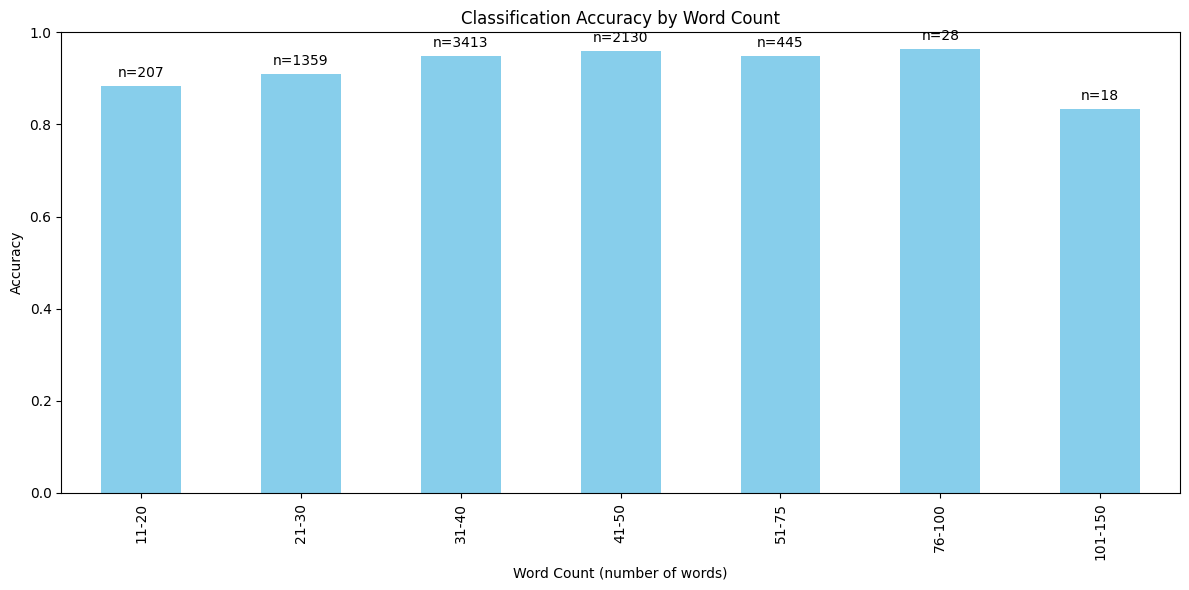


Accuracy by word count:
Word count 11-20: 0.8841 (n=207)
Word count 21-30: 0.9095 (n=1359)
Word count 31-40: 0.9490 (n=3413)
Word count 41-50: 0.9592 (n=2130)
Word count 51-75: 0.9483 (n=445)
Word count 76-100: 0.9643 (n=28)
Word count 101-150: 0.8333 (n=18)


In [63]:
print("Analyzing word count impact on classification accuracy...")
length_results = analyze_text_length_impact(test_dataset, model, tokenizer)

# Bins for word count
length_results['length_bin'] = pd.cut(
    length_results['word_count'],
    bins=[0, 10, 20, 30, 40, 50, 75, 100, 150, 200],
    labels=['1-10', '11-20', '21-30', '31-40', '41-50', '51-75', '76-100', '101-150', '151+']
)

# Accuracy per length bins
accuracy_by_length = length_results.groupby('length_bin')['is_correct'].mean()
counts_by_length = length_results.groupby('length_bin').size()

# Graph of the overall accuracy VS word count
plt.figure(figsize=(12, 6))
ax = accuracy_by_length.plot(kind='bar', color='skyblue')
plt.title('Classification Accuracy by Word Count')
plt.xlabel('Word Count (number of words)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for i, v in enumerate(accuracy_by_length):
    ax.text(i, v + 0.02, f"n={counts_by_length.iloc[i]}", ha='center')

plt.tight_layout()
plt.savefig('accuracy_by_word_count.png')
plt.show()

print("\nAccuracy by word count:")
for length_bin, accuracy in accuracy_by_length.items():
    print(f"Word count {length_bin}: {accuracy:.4f} (n={counts_by_length[length_bin]})")

### Model Interpretability: Attention Analysis

Beyond aggregate performance metrics, we qualitatively inspect attention patterns of the finetuned model.

We visualize attention from the first token ([CLS]-equivalent) to other tokens to better understand how the model processes correctly and incorrectly classified examples.

In [71]:
# Enable attention outputs dynamically during forward pass
classification_model = model
classification_model.eval()

def plot_cls_attention_heatmap(text, model, tokenizer, layer_num=None, head_num=0, title="Attention"):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    if layer_num is None:
        layer_num = len(outputs.attentions) - 1

    attention = outputs.attentions[layer_num][0, head_num]
    cls_attention = attention[0]

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    values = cls_attention[:len(tokens)].cpu().numpy().reshape(1, -1)

    plt.figure(figsize=(12, 1.5))
    ax = sns.heatmap(
        values,
        cmap='YlGnBu',
        cbar=True,
        xticklabels=tokens,
        yticklabels=["CLS →"],
        linewidths=0.3,
        linecolor='gray'
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{title}_heatmap.png')

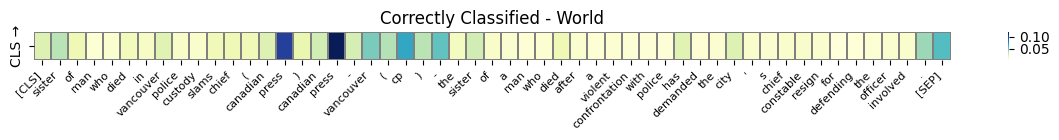

<Figure size 640x480 with 0 Axes>

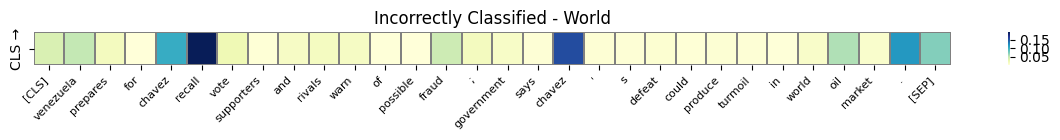

<Figure size 640x480 with 0 Axes>

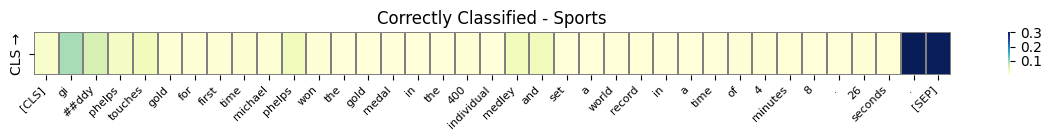

<Figure size 640x480 with 0 Axes>

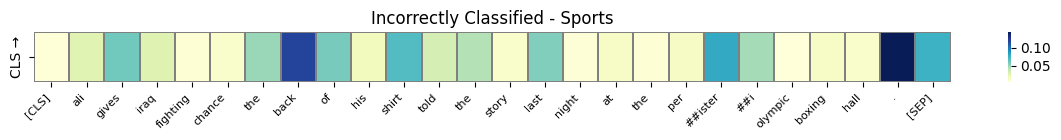

<Figure size 640x480 with 0 Axes>

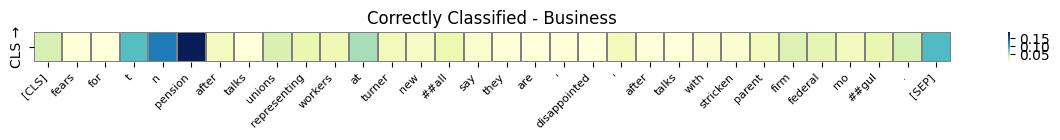

<Figure size 640x480 with 0 Axes>

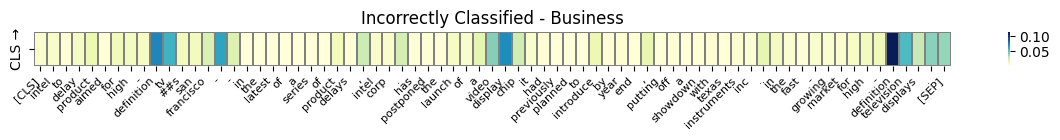

<Figure size 640x480 with 0 Axes>

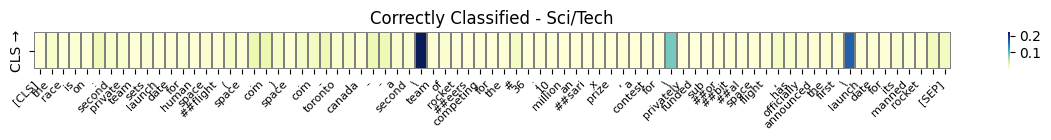

FileNotFoundError: [Errno 2] No such file or directory: 'Correctly Classified - Sci/Tech_heatmap.png'

<Figure size 640x480 with 0 Axes>

In [72]:
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

found_correct = {}
found_incorrect = {}

for i in range(len(test_dataset)):
    item = test_dataset[i]
    text = item['text']
    true_label = item['label']

    inputs = tokenizer(text, return_tensors='pt', truncation=True).to(device)
    with torch.no_grad():
        logits = classification_model(**inputs).logits
        pred_label = torch.argmax(logits, dim=-1).item()

    if pred_label == true_label and true_label not in found_correct:
        found_correct[true_label] = text
    elif pred_label != true_label and true_label not in found_incorrect:
        found_incorrect[true_label] = text

    if len(found_correct) == 4 and len(found_incorrect) == 4:
        break

for label in range(4):
    class_name = label_map[label]

    if label in found_correct:
        plot_cls_attention_heatmap(
            text=found_correct[label],
            model=classification_model,
            tokenizer=tokenizer,
            title=f"Correctly Classified - {class_name}"
        )

    if label in found_incorrect:
        plot_cls_attention_heatmap(
            text=found_incorrect[label],
            model=classification_model,
            tokenizer=tokenizer,
            title=f"Incorrectly Classified - {class_name}"
        )

### Confusion Matrix Analysis

We further examine class-level performance using a confusion matrix on the test set.

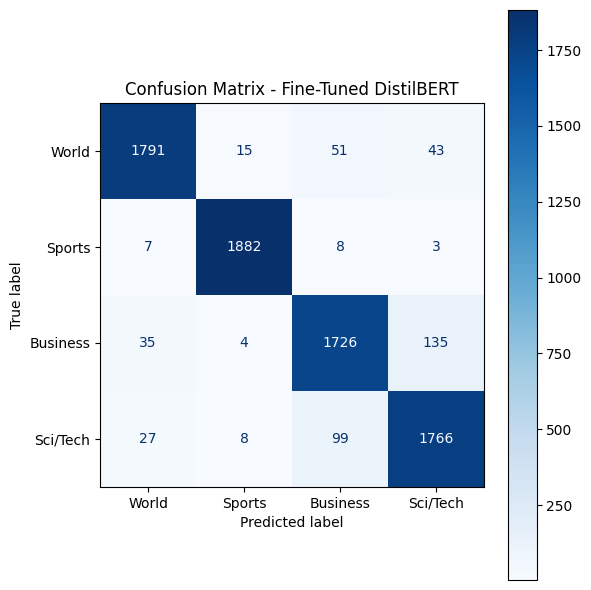

<Figure size 640x480 with 0 Axes>

In [70]:
batch_size = 32
true_labels = []
pred_labels = []

for i in range(0, len(test_dataset), batch_size):
    batch = [test_dataset[j] for j in range(i, min(i + batch_size, len(test_dataset)))]
    texts = [item["text"] for item in batch]
    labels = [item["label"] for item in batch]

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        logits = classification_model(**inputs).logits
        predictions = torch.argmax(logits, dim=-1).tolist()

    true_labels.extend(labels)
    pred_labels.extend(predictions)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Fine-Tuned DistilBERT")
plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix.png')

## Conclusion

This project explored multiple approaches to text classification on AG News:
- Frozen encoder probing with classical models
- End-to-end finetuning
- CNN over contextual embeddings
- Input length performance analysis
- Attention based qualitative interpretability

Finetuning significantly outperformed frozen feature extraction methods, while interpretability analyses provided insight into model behavior across input characteristics.